In [1]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

In [2]:
data = pd.read_csv('EURUSD.txt')
data.head()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,EURUSD,20010102,230100,0.9507,0.9507,0.9507,0.9507,4
1,EURUSD,20010102,230200,0.9506,0.9506,0.9505,0.9505,4
2,EURUSD,20010102,230300,0.9505,0.9507,0.9505,0.9506,4
3,EURUSD,20010102,230400,0.9506,0.9506,0.9506,0.9506,4
4,EURUSD,20010102,230500,0.9506,0.9506,0.9506,0.9506,4


** just get price of each hour **

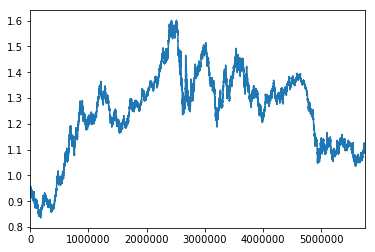

In [3]:
data_sub = data[data['<TIME>']%10000 == 0]['<OPEN>']
data_sub.plot()
plt.show()
del data

In [4]:
data_open = np.array(data_sub)
del data_sub

In [5]:
with open('data_open.pickle', 'wb') as file:
    pickle.dump(data_open, file)

In [6]:
with open('data_open.pickle', 'rb') as file:
    data_open = pickle.load(file)

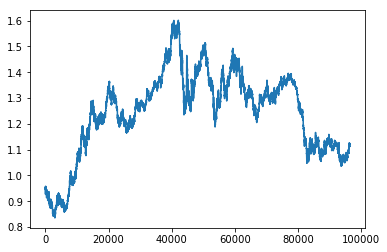

In [7]:
plt.plot(data_open)
plt.show()

# Simple DNN test

In [8]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        #normalised_window = [(p-window.mean())/(window.max() - window.min()) for p in window]
        normalised_window = [100 * ((float(p) - window[0])/window[0]) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def data_prepare(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    mean = data_open.mean()
    interval = data_open.max() - data_open.min()
    data_tmp = [((p - mean)/interval) for p in data_open]
    
    for index in range(len(data_tmp) - sequence_length):
        result.append(data_tmp[index: index + sequence_length])
    
    #if normalise_window:
     #   result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))  

    return [x_train, y_train, x_test, y_test, mean, interval]

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = lambda x : 1/(1+np.exp(-x))
    
    def train(self, inputs, targets):
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs.T)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs# signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        output_errors = targets.T - final_outputs# Output layer error is the difference between desired target and actual output.
        
        # Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors) # errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs)# hidden layer gradients
        
        # Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T)/(inputs.shape[0])# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors * hidden_grad, inputs) / (inputs.shape[0])# update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs):
        #### Implement the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs.T)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs# signals from final output layer 
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [11]:
with open('data_open.pickle', 'rb') as file:
    data_open = pickle.load(file)

In [12]:
x_train, y_train, x_test, y_test, data_mean, data_interval =  data_prepare(data_open, 100, True)

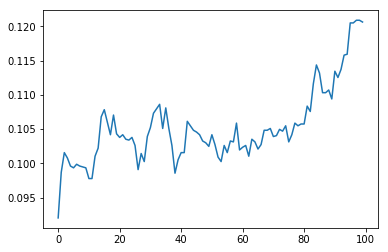

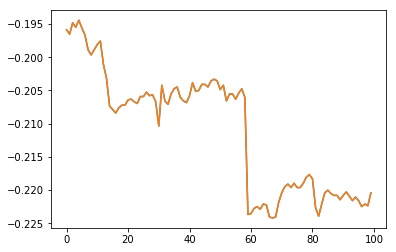

In [13]:
plt.plot(x_train[100])
plt.show()
plt.plot(x_test[100])
plt.plot(y_test[0:100])
plt.show()

In [17]:
import sys

### Set the hyperparameters here ###
epochs = 100
learning_rate = 0.01
hidden_nodes = 300
output_nodes = 1
batch_size = 256
show_every_n_batches = 100

x_train_num = int(x_train.shape[0]*0.9)
x_val_num = x_train.shape[0] - x_train_num

N_i = x_train.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

step = 0
losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    for index in range(0, x_train_num, batch_size):
        step = step+1
        network.train(x_train[index:index+batch_size, :], y_train[index:index+batch_size])
        
        # Printing out the training progress
        if step%show_every_n_batches == 0 :
            train_loss = MSE(network.run(x_train[:x_train_num, :]), y_train[:x_train_num])
            val_loss = MSE(network.run(x_train[x_train_num:, :]), y_train[x_train_num:])
            sys.stdout.write("\rProgress: " + str(100 * step/(float(epochs)*(x_train_num/batch_size)))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:15] \
                     + " ... Validation loss: " + str(val_loss)[:15])
    
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)

Progress: 100.% ... Training loss: 4.69149623984e- ... Validation loss: 4.62831381491e-

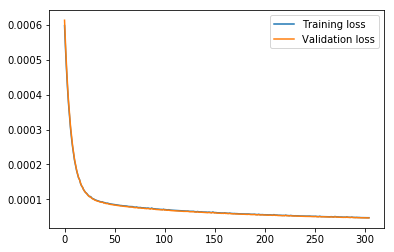

In [18]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()

In [19]:
test_pre = network.run(x_test[:500])

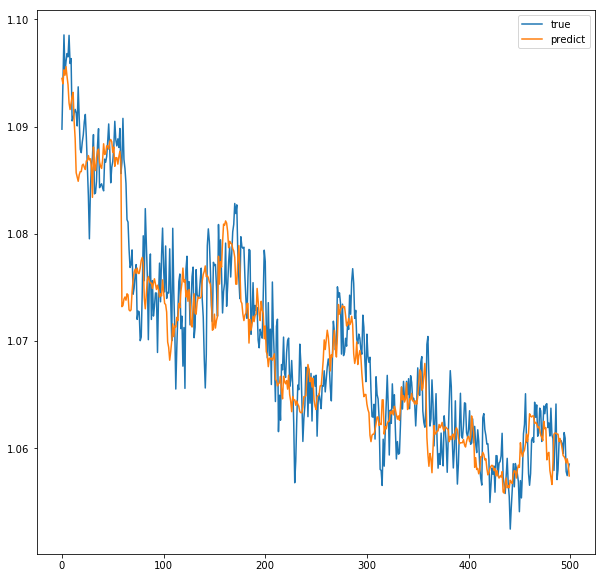

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(test_pre[0, :]*data_interval+data_mean, label='true')
plt.plot(y_test[:500]*data_interval+data_mean, label='predict')
plt.legend()
plt.show()

# Very deep network

In [2]:
class dnn_very_deep(object):
    def __init__(self, input_len, output_len, log_dir = './tensorboard/', model_dir = './model'):
        self.log_dir = log_dir
        self.model_dir = model_dir
        tf.reset_default_graph()
        self.inputs = tf.placeholder(tf.float32, [None, input_len], name='input')
        self.target = tf.placeholder(tf.float32, [None, output_len], name='target')
        self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        self.keep_prob_rate = tf.placeholder(tf.float32, name='keep_prob')
        
        layer_1 = tf.layers.dense(self.inputs, 512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_1 = tf.nn.relu(layer_1)
        layer_1 = tf.nn.dropout(layer_1, self.keep_prob_rate)

        layer_2 = tf.layers.dense(layer_1, 512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, self.keep_prob_rate)

        layer_3 = tf.layers.dense(layer_2, 256, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_3 = tf.nn.relu(layer_3)
        layer_3 = tf.nn.dropout(layer_3, self.keep_prob_rate)

        layer_4 = tf.layers.dense(layer_3, 128, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_4 = tf.nn.relu(layer_4)
        layer_4 = tf.nn.dropout(layer_4, self.keep_prob_rate)

        self.output_layer = tf.layers.dense(layer_4, output_len, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        self.cost = tf.reduce_mean((self.output_layer - self.target)**2)
        self.train_opt = tf.train.AdamOptimizer().minimize(self.cost)
        tf.summary.scalar('lost', self.cost)
        tf.summary.histogram('layer_1', layer_1)
        tf.summary.histogram('layer_2', layer_2)
        tf.summary.histogram('layer_3', layer_3)
        tf.summary.histogram('layer_4', layer_4)
        
    def data_prepare(self, data, seq_len):
        sequence_length = seq_len + 1
        result = []
        self.data_mean = data.mean()
        self.data_interval = data.max() - data.min()
        data_tmp = [((p - self.data_mean)/self.data_interval) for p in data]

        for index in range(len(data_tmp) - sequence_length):
            result.append(data_tmp[index: index + sequence_length])

        result = np.array(result)

        row = round(0.9 * result.shape[0])
        train = result[:int(row), :]
        np.random.shuffle(train)
        self.x_train = train[:, :-1]
        self.y_train = train[:, -1]
        self.x_test = result[int(row):, :-1]
        self.y_test = result[int(row):, -1]

        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1]))
        self.y_train = np.reshape(self.y_train, [-1, 1])
        self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], self.x_test.shape[1]))
        self.y_test = np.reshape(self.y_test, [-1, 1])
        self.saver = None
        
    def train(self, batch_size=256, epochs=1, lr=0.01, keep_prob=1.0, show_every_n_batches=100, re_train=True):
        x_train_num = int(self.x_train.shape[0]*0.9)
        step = 0
        global_step = 0
        losses = {'train':[], 'validation':[]}
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        if re_train == False:
            self.saver.restore(self.sess, self.model_dir+'/model.ckpt')
            with open(self.model_dir+'/step.pickle', 'rb') as file:
                global_step = pickle.load(file)
            print('start record log from step of', global_step, 'in tensorboard')
            
        self.summary = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(self.log_dir+'/train',
                                      self.sess.graph)
        self.val_writer = tf.summary.FileWriter(self.log_dir+'/validation',
                                               self.sess.graph)
            
        for e in range(epochs):
            for index in range(0, x_train_num, batch_size):
                step = step + 1
                train_loss, _, summary = self.sess.run([self.cost, self.train_opt, self.summary], 
                                         feed_dict={
                                            self.inputs:self.x_train[index:index+batch_size, :], 
                                            self.target:self.y_train[index:index+batch_size],
                                            self.learning_rate: lr,
                                            self.keep_prob_rate: keep_prob
                                            })
                
                if step%show_every_n_batches == 0:
                    self.train_writer.add_summary(summary, step + global_step)
                    
                    val_loss, pre, summary = self.sess.run([self.cost, self.output_layer, self.summary], 
                                             feed_dict={
                                                self.inputs:self.x_train[x_train_num:], 
                                                self.target:self.y_train[x_train_num:],
                                                self.keep_prob_rate: keep_prob
                                                })
                    self.val_writer.add_summary(summary, step + global_step)
                    
                    print("echop:", e,
                          "processing:", str(100 * step/(float(epochs)*(x_train_num/batch_size)))[:4], "%\n",
                          "train loss is: ", str(train_loss)[:15], 
                          "validation loss is:", str(val_loss)[:15])
                    losses['train'].append(train_loss)
                    losses['validation'].append(val_loss)
                    
        test_loss, pre = self.sess.run([self.cost, self.output_layer], feed_dict={
                                            self.inputs:self.x_test, 
                                            self.target:self.y_test,
                                            self.keep_prob_rate: 1.0
                                            })
        print("test lost is:", test_loss)
        
        self.saver.save(self.sess, self.model_dir+'/model.ckpt')
        with open(self.model_dir+'/step.pickle', 'wb') as file:
            pickle.dump(step + global_step, file)
            
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("predict and acc")
        plt.plot(self.y_test[:500]*self.data_interval+self.data_mean, label='true')
        plt.plot(pre[:500]*self.data_interval+self.data_mean, label='predict')
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("loss record")
        plt.plot(losses['train'], label='Training loss')
        plt.plot(losses['validation'], label='Validation loss')
        plt.legend()
        plt.show()
        
    def predict(self, input_data):
        with tf.Session() as sess:
            self.saver = tf.train.Saver()
            self.saver.restore(sess, self.model_dir+'/model.ckpt')
            predict_output = sess.run(self.output_layer, feed_dict={
                                                self.inputs:input_data, 
                                                self.keep_prob_rate: 1.0
                                                })
        return predict_output*self.data_interval+self.data_mean

In [3]:
with open('data_open.pickle', 'rb') as file:
    data_open = pickle.load(file)

In [4]:
rm -rf ./tensorboard/very_deep_dnn/*

In [5]:
very_deep_dnn_model_dir = './model/very_deep_model'
very_deep_dnn_log_dir = './tensorboard/very_deep_dnn'

echop: 0 processing: 0.10 %
 train loss is:  0.000369406 validation loss is: 0.000357647
echop: 0 processing: 0.21 %
 train loss is:  0.000169015 validation loss is: 0.000195398
echop: 0 processing: 0.32 %
 train loss is:  0.000160414 validation loss is: 0.000154362
echop: 1 processing: 0.43 %
 train loss is:  0.000103252 validation loss is: 0.000116328
echop: 1 processing: 0.54 %
 train loss is:  9.19446e-05 validation loss is: 8.77737e-05
echop: 1 processing: 0.65 %
 train loss is:  7.85414e-05 validation loss is: 6.25374e-05
echop: 2 processing: 0.76 %
 train loss is:  4.34743e-05 validation loss is: 7.79983e-05
echop: 2 processing: 0.87 %
 train loss is:  6.0301e-05 validation loss is: 6.40498e-05
echop: 2 processing: 0.98 %
 train loss is:  5.06985e-05 validation loss is: 4.90008e-05
echop: 3 processing: 1.09 %
 train loss is:  0.000146596 validation loss is: 5.76238e-05
echop: 3 processing: 1.20 %
 train loss is:  4.14815e-05 validation loss is: 8.02844e-05
echop: 3 processing: 1

echop: 30 processing: 10.2 %
 train loss is:  2.58435e-05 validation loss is: 2.27407e-05
echop: 30 processing: 10.3 %
 train loss is:  1.23361e-05 validation loss is: 1.20436e-05
echop: 31 processing: 10.4 %
 train loss is:  3.51045e-05 validation loss is: 1.30562e-05
echop: 31 processing: 10.5 %
 train loss is:  1.40581e-05 validation loss is: 1.4923e-05
echop: 31 processing: 10.6 %
 train loss is:  4.06458e-05 validation loss is: 1.83952e-05
echop: 32 processing: 10.7 %
 train loss is:  5.82131e-05 validation loss is: 4.15102e-05
echop: 32 processing: 10.8 %
 train loss is:  1.15043e-05 validation loss is: 2.04312e-05
echop: 32 processing: 10.9 %
 train loss is:  1.86649e-05 validation loss is: 1.8577e-05
echop: 33 processing: 11.0 %
 train loss is:  1.7038e-05 validation loss is: 3.05887e-05
echop: 33 processing: 11.1 %
 train loss is:  3.03267e-05 validation loss is: 1.5536e-05
echop: 33 processing: 11.2 %
 train loss is:  1.837e-05 validation loss is: 1.13924e-05
echop: 34 proces

echop: 60 processing: 20.2 %
 train loss is:  1.98635e-05 validation loss is: 3.08937e-05
echop: 61 processing: 20.4 %
 train loss is:  1.73593e-05 validation loss is: 1.11416e-05
echop: 61 processing: 20.5 %
 train loss is:  8.38491e-06 validation loss is: 8.9589e-06
echop: 61 processing: 20.6 %
 train loss is:  6.55676e-06 validation loss is: 9.05141e-06
echop: 62 processing: 20.7 %
 train loss is:  2.21627e-05 validation loss is: 9.68293e-06
echop: 62 processing: 20.8 %
 train loss is:  1.21793e-05 validation loss is: 1.26627e-05
echop: 62 processing: 20.9 %
 train loss is:  7.09671e-06 validation loss is: 1.02856e-05
echop: 63 processing: 21.0 %
 train loss is:  2.38166e-05 validation loss is: 1.87485e-05
echop: 63 processing: 21.1 %
 train loss is:  1.77465e-05 validation loss is: 1.29268e-05
echop: 63 processing: 21.2 %
 train loss is:  7.31718e-06 validation loss is: 8.91365e-06
echop: 64 processing: 21.3 %
 train loss is:  1.72287e-05 validation loss is: 3.09637e-05
echop: 64 p

echop: 91 processing: 30.3 %
 train loss is:  6.0286e-06 validation loss is: 7.46865e-06
echop: 91 processing: 30.4 %
 train loss is:  1.20475e-05 validation loss is: 9.50634e-06
echop: 91 processing: 30.6 %
 train loss is:  6.1718e-06 validation loss is: 8.31906e-06
echop: 92 processing: 30.7 %
 train loss is:  1.41853e-05 validation loss is: 2.16801e-05
echop: 92 processing: 30.8 %
 train loss is:  1.61482e-05 validation loss is: 1.00196e-05
echop: 92 processing: 30.9 %
 train loss is:  2.53839e-05 validation loss is: 1.54416e-05
echop: 93 processing: 31.0 %
 train loss is:  1.13185e-05 validation loss is: 1.27786e-05
echop: 93 processing: 31.1 %
 train loss is:  1.39536e-05 validation loss is: 9.3704e-06
echop: 93 processing: 31.2 %
 train loss is:  5.18644e-06 validation loss is: 8.65011e-06
echop: 94 processing: 31.3 %
 train loss is:  6.73942e-06 validation loss is: 7.14978e-06
echop: 94 processing: 31.4 %
 train loss is:  1.14077e-05 validation loss is: 9.31248e-06
echop: 94 pro

echop: 121 processing: 40.3 %
 train loss is:  1.13733e-05 validation loss is: 7.98651e-06
echop: 121 processing: 40.4 %
 train loss is:  7.19924e-06 validation loss is: 7.41594e-06
echop: 121 processing: 40.5 %
 train loss is:  1.11527e-05 validation loss is: 1.61358e-05
echop: 122 processing: 40.6 %
 train loss is:  8.61311e-06 validation loss is: 6.42754e-06
echop: 122 processing: 40.8 %
 train loss is:  6.28902e-06 validation loss is: 6.8313e-06
echop: 122 processing: 40.9 %
 train loss is:  7.96884e-06 validation loss is: 6.81256e-06
echop: 123 processing: 41.0 %
 train loss is:  6.31632e-06 validation loss is: 7.28774e-06
echop: 123 processing: 41.1 %
 train loss is:  7.81583e-06 validation loss is: 8.2186e-06
echop: 123 processing: 41.2 %
 train loss is:  6.23337e-06 validation loss is: 7.92261e-06
echop: 124 processing: 41.3 %
 train loss is:  7.5734e-06 validation loss is: 8.81186e-06
echop: 124 processing: 41.4 %
 train loss is:  8.60601e-06 validation loss is: 7.87784e-06
ec

echop: 150 processing: 50.3 %
 train loss is:  9.14923e-06 validation loss is: 6.35504e-06
echop: 151 processing: 50.4 %
 train loss is:  1.65994e-05 validation loss is: 1.33927e-05
echop: 151 processing: 50.5 %
 train loss is:  9.19051e-06 validation loss is: 1.25272e-05
echop: 151 processing: 50.6 %
 train loss is:  6.21191e-06 validation loss is: 7.64885e-06
echop: 152 processing: 50.7 %
 train loss is:  6.53456e-06 validation loss is: 1.58636e-05
echop: 152 processing: 50.8 %
 train loss is:  8.36312e-06 validation loss is: 6.91152e-06
echop: 152 processing: 51.0 %
 train loss is:  6.42805e-06 validation loss is: 6.86612e-06
echop: 153 processing: 51.1 %
 train loss is:  5.69815e-06 validation loss is: 7.24435e-06
echop: 153 processing: 51.2 %
 train loss is:  5.59516e-06 validation loss is: 7.74223e-06
echop: 153 processing: 51.3 %
 train loss is:  9.65706e-06 validation loss is: 9.56221e-06
echop: 154 processing: 51.4 %
 train loss is:  1.06502e-05 validation loss is: 6.57761e-06

echop: 185 processing: 61.7 %
 train loss is:  1.68875e-05 validation loss is: 7.82032e-06
echop: 185 processing: 61.8 %
 train loss is:  4.91146e-06 validation loss is: 1.02754e-05
echop: 185 processing: 61.9 %
 train loss is:  1.19768e-05 validation loss is: 1.1194e-05
echop: 186 processing: 62.0 %
 train loss is:  1.79876e-05 validation loss is: 1.08835e-05
echop: 186 processing: 62.1 %
 train loss is:  5.1452e-06 validation loss is: 1.18415e-05
echop: 186 processing: 62.2 %
 train loss is:  8.75e-06 validation loss is: 7.37381e-06
echop: 187 processing: 62.4 %
 train loss is:  7.50279e-06 validation loss is: 1.19968e-05
echop: 187 processing: 62.5 %
 train loss is:  9.57375e-06 validation loss is: 5.94558e-06
echop: 187 processing: 62.6 %
 train loss is:  1.15544e-05 validation loss is: 1.20342e-05
echop: 188 processing: 62.7 %
 train loss is:  1.79237e-05 validation loss is: 1.91814e-05
echop: 188 processing: 62.8 %
 train loss is:  7.80477e-06 validation loss is: 1.42126e-05
echo

echop: 215 processing: 71.7 %
 train loss is:  1.55428e-05 validation loss is: 1.13078e-05
echop: 215 processing: 71.8 %
 train loss is:  6.16125e-06 validation loss is: 6.91912e-06
echop: 215 processing: 71.9 %
 train loss is:  5.78928e-06 validation loss is: 7.91368e-06
echop: 216 processing: 72.0 %
 train loss is:  6.2691e-06 validation loss is: 7.91763e-06
echop: 216 processing: 72.1 %
 train loss is:  1.0038e-05 validation loss is: 5.99842e-06
echop: 216 processing: 72.2 %
 train loss is:  4.85016e-06 validation loss is: 6.10353e-06
echop: 217 processing: 72.3 %
 train loss is:  8.60071e-06 validation loss is: 8.74054e-06
echop: 217 processing: 72.4 %
 train loss is:  6.08545e-06 validation loss is: 6.08766e-06
echop: 217 processing: 72.6 %
 train loss is:  7.69347e-06 validation loss is: 7.74607e-06
echop: 218 processing: 72.7 %
 train loss is:  1.29275e-05 validation loss is: 1.69045e-05
echop: 218 processing: 72.8 %
 train loss is:  5.77369e-06 validation loss is: 6.12039e-06
e

echop: 245 processing: 81.7 %
 train loss is:  5.78038e-06 validation loss is: 6.40565e-06
echop: 245 processing: 81.8 %
 train loss is:  8.18972e-06 validation loss is: 5.86802e-06
echop: 245 processing: 81.9 %
 train loss is:  6.33204e-06 validation loss is: 8.85449e-06
echop: 246 processing: 82.0 %
 train loss is:  8.25945e-06 validation loss is: 5.71355e-06
echop: 246 processing: 82.1 %
 train loss is:  6.65203e-06 validation loss is: 6.01426e-06
echop: 246 processing: 82.2 %
 train loss is:  5.37202e-06 validation loss is: 6.34326e-06
echop: 247 processing: 82.3 %
 train loss is:  8.44913e-06 validation loss is: 6.30146e-06
echop: 247 processing: 82.4 %
 train loss is:  5.75986e-06 validation loss is: 7.05174e-06
echop: 247 processing: 82.5 %
 train loss is:  7.74355e-06 validation loss is: 5.87661e-06
echop: 248 processing: 82.6 %
 train loss is:  5.47842e-06 validation loss is: 6.16255e-06
echop: 248 processing: 82.8 %
 train loss is:  6.44184e-06 validation loss is: 6.84691e-06

echop: 274 processing: 91.6 %
 train loss is:  3.86082e-06 validation loss is: 6.25344e-06
echop: 275 processing: 91.8 %
 train loss is:  8.14804e-06 validation loss is: 6.60218e-06
echop: 275 processing: 91.9 %
 train loss is:  8.18576e-06 validation loss is: 7.80889e-06
echop: 275 processing: 92.0 %
 train loss is:  7.92314e-06 validation loss is: 6.44372e-06
echop: 276 processing: 92.1 %
 train loss is:  1.0901e-05 validation loss is: 6.93061e-06
echop: 276 processing: 92.2 %
 train loss is:  1.06631e-05 validation loss is: 1.37848e-05
echop: 276 processing: 92.3 %
 train loss is:  4.89804e-06 validation loss is: 6.34e-06
echop: 277 processing: 92.4 %
 train loss is:  5.39031e-06 validation loss is: 1.03992e-05
echop: 277 processing: 92.5 %
 train loss is:  7.80635e-06 validation loss is: 5.52386e-06
echop: 277 processing: 92.6 %
 train loss is:  7.5444e-06 validation loss is: 1.00024e-05
echop: 278 processing: 92.7 %
 train loss is:  5.64239e-06 validation loss is: 5.88483e-06
echo

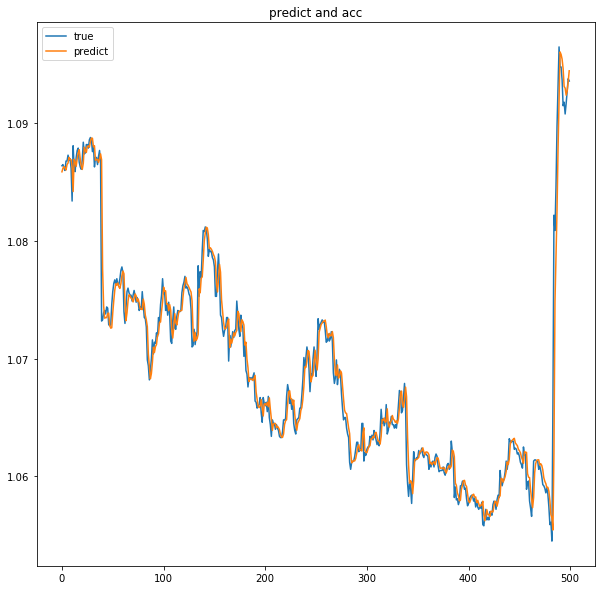

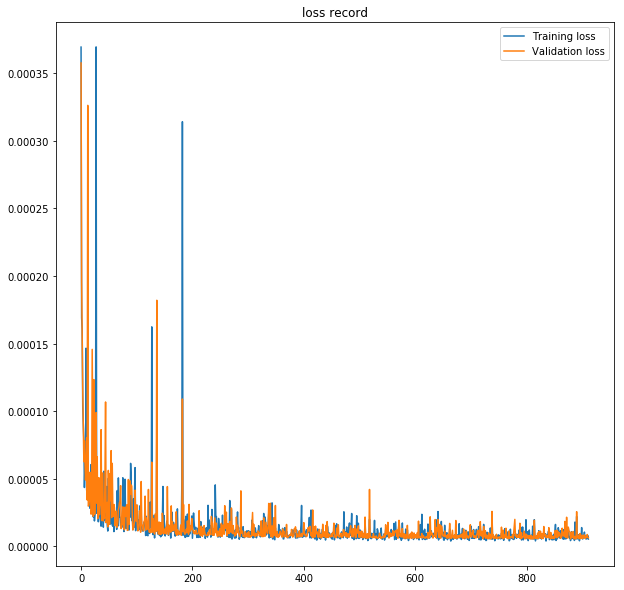

In [ ]:
seq_length = 300
exchange_dnn_mode = dnn_very_deep(seq_length, 1, very_deep_dnn_log_dir, very_deep_dnn_model_dir)
exchange_dnn_mode.data_prepare(data_open, seq_length)
exchange_dnn_mode.train(epochs = 300)

In [ ]:
exchange_dnn_mode.predict(exchange_dnn_mode.x_test[:10])

INFO:tensorflow:Restoring parameters from ./model/very_deep_model/model.ckpt


array([[ 1.08588469],
       [ 1.08619082],
       [ 1.08633709],
       [ 1.08620214],
       [ 1.08603644],
       [ 1.08649898],
       [ 1.08663046],
       [ 1.08710623],
       [ 1.08694935],
       [ 1.08691537]], dtype=float32)

In [ ]:
del exchange_dnn_mode

In [ ]:
del data_open

# Add more feature

In [13]:
data = pd.read_csv('EURUSD.txt')

In [51]:
data_hours_index = data[data['<TIME>']%10000 == 0].index

data_sub [OPEN, HIGH, LOW, CLOSE] in each hour

In [101]:
data_sub = []
for i in range(len(data_hours_index)-1):
    data_tmp = data.iloc[data_hours_index[i]:data_hours_index[i+1]]
    data_sub.append([float(data.iloc[data_hours_index[i]]['<OPEN>']), float(data_tmp['<HIGH>'].max()), 
        float(data_tmp['<LOW>'].min()), float(data.iloc[data_hours_index[i+1]]['<OPEN>'])])
data_sub = np.array(data_sub)

In [102]:
data_sub

array([[ 0.9506,  0.951 ,  0.9492,  0.9496],
       [ 0.9496,  0.9509,  0.9495,  0.9504],
       [ 0.9504,  0.9508,  0.9498,  0.9499],
       ..., 
       [ 1.1231,  1.1242,  1.123 ,  1.1241],
       [ 1.1241,  1.1246,  1.1239,  1.1242],
       [ 1.1242,  1.1242,  1.1234,  1.1237]])

In [110]:
with open('data_more_feature_hours.pickle', 'wb') as file:
    pickle.dump(data_sub, file)

In [3]:
with open('data_more_feature_hours.pickle', 'rb') as file:
    data_more_feature = pickle.load(file)

In [4]:
class dnn_more_feature(dnn_very_deep):
    def __init__(self, input_len, output_len, log_dir, model_dir):
        self.log_dir = log_dir
        self.model_dir = model_dir
        tf.reset_default_graph()
        self.inputs = tf.placeholder(tf.float32, [None, input_len], name='input')
        self.target = tf.placeholder(tf.float32, [None, output_len], name='target')
        self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        self.keep_prob_rate = tf.placeholder(tf.float32, name='keep_prob')
        
        layer_1 = tf.layers.dense(self.inputs, 2048, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_1 = tf.nn.relu(layer_1)
        layer_1 = tf.nn.dropout(layer_1, self.keep_prob_rate)
        
        layer_2 = tf.layers.dense(layer_1, 1024, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, self.keep_prob_rate)

        layer_3 = tf.layers.dense(layer_2, 512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_3 = tf.nn.relu(layer_3)
        layer_3 = tf.nn.dropout(layer_3, self.keep_prob_rate)
        
        self.output_layer = tf.layers.dense(layer_3, output_len, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        self.cost = tf.reduce_mean((self.output_layer - self.target)**2)
        self.train_opt = tf.train.AdamOptimizer().minimize(self.cost)
        tf.summary.scalar('lost', self.cost)
        #tf.summary.histogram('layer_1', layer_1)
        #tf.summary.histogram('layer_2', layer_2)
        
        
    def data_prepare(self, data, seq_len):
        sequence_length = seq_len + 1
        result = []
        self.data_mean = data.mean()
        self.data_interval = data.max() - data.min()
        data_tmp = (data - data.mean(axis = 0))/self.data_interval

        for index in range(len(data_tmp) - sequence_length):
            result.append(np.reshape(data_tmp[index: index + sequence_length], [1, -1]))
            
        del data_tmp
        result = np.array(result)
        result = np.reshape(result, [result.shape[0], -1])
        row = round(0.9 * result.shape[0])
        train = result[:int(row)]
        np.random.shuffle(train)
        self.x_train = train[:, :-data.shape[1]]
        self.y_train = np.reshape(train[:, -1], [-1, 1])
        self.x_test = result[int(row):, :-data.shape[1]]
        self.y_test = np.reshape(result[int(row):, -1], [-1, 1])
        self.saver = None

In [5]:
rm -rf ./tensorboard/dnn_more_feature/*

In [6]:
dnn_more_feature_model_dir = './model/dnn_more_feature'
dnn_more_feature_log_dir = './tensorboard/dnn_more_feature'

In [7]:
seq_length = 300 #result of 100 is better
exchange_dnn_mode = dnn_more_feature(seq_length*data_more_feature.shape[1], 1, 
                                     dnn_more_feature_log_dir, dnn_more_feature_model_dir)
exchange_dnn_mode.data_prepare(data_more_feature, seq_length)

INFO:tensorflow:Restoring parameters from ./model/dnn_more_feature/model.ckpt
start record log from step of 125856 in tensorboard
echop: 0 processing: 0.65 %
 train loss is:  7.88517e-06 validation loss is: 7.38267e-06
echop: 1 processing: 1.31 %
 train loss is:  5.7553e-06 validation loss is: 6.67803e-06
echop: 1 processing: 1.97 %
 train loss is:  7.7699e-06 validation loss is: 1.00358e-05
echop: 2 processing: 2.63 %
 train loss is:  6.63712e-06 validation loss is: 6.8475e-06
echop: 3 processing: 3.29 %
 train loss is:  5.69589e-06 validation loss is: 7.10436e-06
echop: 3 processing: 3.94 %
 train loss is:  7.83375e-06 validation loss is: 8.32088e-06
echop: 4 processing: 4.60 %
 train loss is:  9.72035e-06 validation loss is: 1.14169e-05
echop: 5 processing: 5.26 %
 train loss is:  6.56512e-06 validation loss is: 7.4758e-06
echop: 5 processing: 5.92 %
 train loss is:  6.42557e-06 validation loss is: 6.73714e-06
echop: 6 processing: 6.58 %
 train loss is:  7.15546e-06 validation loss 

echop: 59 processing: 59.8 %
 train loss is:  6.50452e-06 validation loss is: 6.95012e-06
echop: 60 processing: 60.5 %
 train loss is:  7.00127e-06 validation loss is: 6.55008e-06
echop: 61 processing: 61.2 %
 train loss is:  1.13467e-05 validation loss is: 6.38933e-06
echop: 61 processing: 61.8 %
 train loss is:  5.92637e-06 validation loss is: 7.2093e-06
echop: 62 processing: 62.5 %
 train loss is:  6.2363e-06 validation loss is: 6.95691e-06
echop: 63 processing: 63.1 %
 train loss is:  9.25651e-06 validation loss is: 6.35863e-06
echop: 63 processing: 63.8 %
 train loss is:  8.15703e-06 validation loss is: 7.30564e-06
echop: 64 processing: 64.4 %
 train loss is:  7.99131e-05 validation loss is: 4.13238e-05
echop: 65 processing: 65.1 %
 train loss is:  9.82273e-06 validation loss is: 9.37991e-06
echop: 65 processing: 65.8 %
 train loss is:  1.02382e-05 validation loss is: 7.37335e-06
echop: 66 processing: 66.4 %
 train loss is:  8.27641e-06 validation loss is: 8.73077e-06
echop: 67 pr

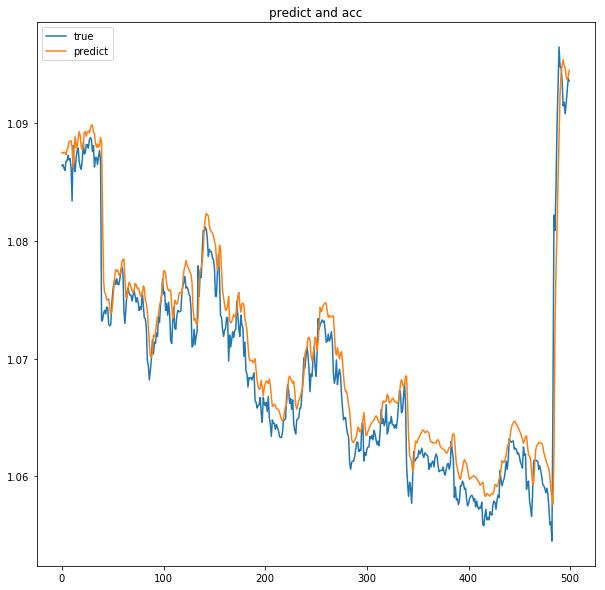

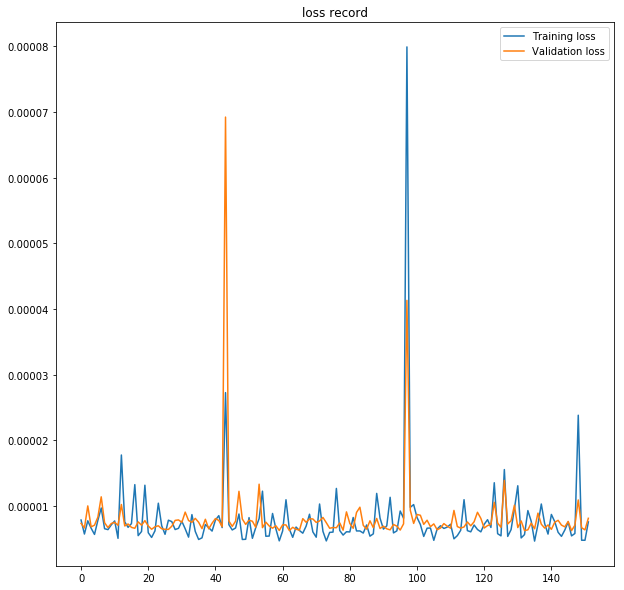

In [15]:
exchange_dnn_mode.train(epochs = 100, batch_size=512, re_train=False) #take bigger batch_size will cause more stable loss

In [10]:
np.sqrt(4.65588e-06) * exchange_dnn_mode.data_interval

0.0016584457483574191

In [ ]:
exchange_dnn_mode.data_interval

In [ ]:
del exchange_dnn_mode

# Predict the trend

In [2]:
with open('data_open.pickle', 'rb') as file:
    data_open = pickle.load(file)

In [ ]:
with open('data_more_feature_hours.pickle', 'rb') as file:
    data_more_feature = pickle.load(file)

In [ ]:
class dnn_trend_model(object):
    def __init__(self, input_len, output_len, log_dir, model_dir):
        self.log_dir = log_dir
        self.model_dir = model_dir
        tf.reset_default_graph()
        self.inputs = tf.placeholder(tf.float32, [None, input_len], name='input')
        self.target = tf.placeholder(tf.float32, [None, output_len], name='target')
        self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        self.keep_prob_rate = tf.placeholder(tf.float32, name='keep_prob')
        
        layer_1 = tf.layers.dense(self.inputs, 2048, kernel_initializer=tf.truncated_normal_initializer(stddev=0.00001))
        layer_1 = tf.nn.relu(layer_1)
        layer_1 = tf.nn.dropout(layer_1, self.keep_prob_rate)
        
        layer_2 = tf.layers.dense(layer_1, 1024, kernel_initializer=tf.truncated_normal_initializer(stddev=0.00001))
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, self.keep_prob_rate)

        layer_3 = tf.layers.dense(layer_2, 512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.00001))
        layer_3 = tf.nn.relu(layer_3)
        layer_3 = tf.nn.dropout(layer_3, self.keep_prob_rate)
        
        self.output_layer = tf.layers.dense(layer_3, output_len, kernel_initializer=tf.truncated_normal_initializer(stddev=0.00001))
        #self.output_layer = tf.sigmoid(self.output_layer)
        #self.cost = tf.losses.mean_squared_error(self.target, self.output_layer)
        self.cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=self.output_layer, labels=self.target)
        self.cost = tf.reduce_mean(self.cross_entropy)
        self.train_opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
        self.predict = tf.sigmoid(self.output_layer)
        tf.summary.scalar('lost', self.cost)
        #tf.summary.histogram('layer_1', layer_1)
        #tf.summary.histogram('layer_2', layer_2)
        
        
    def data_prepare(self, data, seq_len):
        sequence_length = seq_len + 1
        result = []
        self.data_mean = data.mean()
        self.data_interval = data.max() - data.min()
        data_tmp = (data - data.mean(axis = 0))/self.data_interval

        for index in range(len(data_tmp) - sequence_length):
            result.append(np.reshape(data_tmp[index: index + sequence_length], [1, -1]))
            
        del data_tmp
        result = np.array(result)
        result = np.reshape(result, [result.shape[0], -1])
        row = round(0.9 * result.shape[0])
        train = result[:int(row)]
        np.random.shuffle(train)
        self.x_train = train[:, :-data.shape[1]]
        self.y_train = 1*np.reshape(np.array([(train[:, -1] - self.x_train[:, -1]) > 0]), [-1, 1])
        self.x_test = result[int(row):, :-data.shape[1]]
        self.y_test = 1*np.reshape(np.array([(result[int(row):, -1] - self.x_test[:, -1]) > 0]), [-1, 1])
        self.saver = None
        
    def train(self, batch_size=256, epochs=1, lr=0.01, keep_prob=1.0, show_every_n_batches=100, re_train=True):
        x_train_num = int(self.x_train.shape[0]*0.9)
        step = 0
        global_step = 0
        losses = {'train':[], 'validation':[]}
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        if re_train == False:
            self.saver.restore(self.sess, self.model_dir+'/model.ckpt')
            with open(self.model_dir+'/step.pickle', 'rb') as file:
                global_step = pickle.load(file)
            print('start record log from step of', global_step, 'in tensorboard')
            
        self.summary = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(self.log_dir+'/train',
                                      self.sess.graph)
        self.val_writer = tf.summary.FileWriter(self.log_dir+'/validation',
                                               self.sess.graph)
            
        for e in range(epochs):
            for index in range(0, x_train_num, batch_size):
                step = step + 1
                train_loss, _, summary = self.sess.run([self.cost, self.train_opt, self.summary], 
                                         feed_dict={
                                            self.inputs:self.x_train[index:index+batch_size, :], 
                                            self.target:self.y_train[index:index+batch_size],
                                            self.learning_rate: lr,
                                            self.keep_prob_rate: keep_prob
                                            })
                
                if step%show_every_n_batches == 0:
                    self.train_writer.add_summary(summary, step + global_step)
                    
                    val_loss, pre, summary = self.sess.run([self.cost, self.predict, self.summary], 
                                             feed_dict={
                                                self.inputs:self.x_train[x_train_num:], 
                                                self.target:self.y_train[x_train_num:],
                                                self.keep_prob_rate: keep_prob
                                                })
                    self.val_writer.add_summary(summary, step + global_step)
                    
                    print("echop:", e,
                          "processing:", str(100 * step/(float(epochs)*(x_train_num/batch_size)))[:4], "%\n",
                          "train loss is: ", str(train_loss)[:15], 
                          "validation loss is:", str(val_loss)[:15])
                    losses['train'].append(train_loss)
                    losses['validation'].append(val_loss)
                    
        test_loss, pre = self.sess.run([self.cost, self.predict], feed_dict={
                                            self.inputs:self.x_test, 
                                            self.target:self.y_test,
                                            self.keep_prob_rate: 1.0
                                            })
        print("test lost is:", test_loss)
        
        self.saver.save(self.sess, self.model_dir+'/model.ckpt')
        with open(self.model_dir+'/step.pickle', 'wb') as file:
            pickle.dump(step + global_step, file)
            
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("predict and acc")
        plt.plot(self.y_test[:500], label='true')
        plt.plot(pre[:500], label='predict')
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("loss record")
        plt.plot(losses['train'], label='Training loss')
        plt.plot(losses['validation'], label='Validation loss')
        plt.legend()
        plt.show()
        
    def predict(self, input_data):
        with tf.Session() as sess:
            self.saver = tf.train.Saver()
            self.saver.restore(sess, self.model_dir+'/model.ckpt')
            predict_output = sess.run(self.output_layer, feed_dict={
                                                self.inputs:input_data, 
                                                self.keep_prob_rate: 1.0
                                                })
        return predict_output*self.data_interval+self.data_mean

In [ ]:
rm -rf ./tensorboard/dnn_trend_model/*

In [ ]:
dnn_trend_model_dir = './model/dnn_trend_model'
dnn_trend_model_log_dir = './tensorboard/dnn_trend_model'

In [ ]:
seq_length = 300
exchange_dnn_trend_mode = dnn_trend_model(seq_length*data_more_feature.shape[1], 1, 
                                     dnn_trend_model_log_dir, dnn_trend_model_dir)
exchange_dnn_trend_mode.data_prepare(data_more_feature, seq_length)
exchange_dnn_trend_mode.train(epochs = 2, lr=0.01, re_train=True)

In [43]:
np.sum(exchange_dnn_trend_mode.y_train)/len(exchange_dnn_trend_mode.y_train)

0.480138986690062

## TODO:

**try to add normalize layer in the DNN**

**try to predict the price after 5 hours**

**try to predict the trend**